In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['font.sans-serif']=['Microsoft Yahei']
plt.style.use("ggplot")

<div class="jumbotron">
    <h1 class="display-1">分类技术：进阶</h1>
    <hr class="my-4">
    <p>主讲：李岩</p>
    <p>管理学院</p>
    <p>liyan@cumtb.edu.cn</p>
</div>

## 分类技术在评价中的应用

- 数据集记录了151名助教在5个学期中的教学效果的评估，评估结果分别是“差”、“一般”、“好”。数据属性的含义如下表所示：

No.|含义|取值
---|---|---
1|助教是否以英语为母语|二元变量，1=是，2=否
2|课程的讲师|分类变量，25个类别
3|课程|分类变量，26个类别
4|暑期或正常学期|二元变量，1=暑期，2=正常学期
5|班级大小|整数
6|评估结果|1=差，2=一般，3=好

### 读取数据

In [3]:
tadf = pd.read_csv('./data/classificationSupplement/tae.txt')
tadf.head()

,1,23,3,1.1,19,3.1
0,2,15,3,1,17,3
1,1,23,3,2,49,3
2,1,5,2,2,33,3
3,2,7,11,2,55,3
4,2,23,3,1,20,3


- 原始数据不含有属性（列）名，用上述方式导致将第一行数据作为列名，这种读取方式不正确

In [4]:
tadf = pd.read_csv('./data/classificationSupplement/tae.txt',names=['english','instructor','course','period','size','label'])
tadf.head()

,english,instructor,course,period,size,label
0,1,23,3,1,19,3
1,2,15,3,1,17,3
2,1,23,3,2,49,3
3,1,5,2,2,33,3
4,2,7,11,2,55,3


### 数据预处理

#### 缺失值检验

In [5]:
tadf.isna().sum(axis=0)

english       0
instructor    0
course        0
period        0
size          0
label         0
dtype: int64

- 不存在缺失值

#### `one-hot`编码

- 将评估结果列和其他属性分开

In [6]:
taX = tadf.iloc[:,:-1]
taY = tadf['label']
taX.head()
taY.head()

,english,instructor,course,period,size
0,1,23,3,1,19
1,2,15,3,1,17
2,1,23,3,2,49
3,1,5,2,2,33
4,2,7,11,2,55


0    3
1    3
2    3
3    3
4    3
Name: label, dtype: int64

- 对预测属性进行`one-hot`编码

In [7]:
taXOH = pd.get_dummies(taX,columns=['english','instructor','course','period'])
taXOH.head()

,size,english_1,english_2,instructor_1,instructor_2,instructor_3,instructor_4,instructor_5,instructor_6,instructor_7,...,course_19,course_20,course_21,course_22,course_23,course_24,course_25,course_26,period_1,period_2
0,19,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,17,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,49,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,33,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,55,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


### 分割训练集与检验集

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
taTrainX,taTestX,taTrainY,taTestY = train_test_split(taXOH,taY,test_size=0.25,random_state=10, stratify=taY)

- `stratify`：`None`或数组，如果是数组，表明按照类别分层抽样组成训练集和检验集，使得训练集和检验集中的类别的比例与原始数据集的类别比例近似相等

In [10]:
taTrainY.value_counts(normalize=True)      #训练集的类别比例
taTestY.value_counts(normalize=True)      #检验集的类别比例
taY.value_counts(normalize=True)          #原始数据的类别比例

3    0.345133
2    0.327434
1    0.327434
Name: label, dtype: float64

3    0.342105
2    0.342105
1    0.315789
Name: label, dtype: float64

3    0.344371
2    0.331126
1    0.324503
Name: label, dtype: float64

### 建立神经网络模型

In [11]:
from sklearn.neural_network import MLPClassifier

- 输入层神经元数量：56
    + `one-hot`编码后的预测属性的数量

- 输出层神经元数量：3
    + 评估类别的数量

- 隐藏层神经元数量：13

In [12]:
np.sqrt(56*3)

12.96148139681572

In [13]:
taAnn = MLPClassifier(hidden_layer_sizes=(13,),solver='lbfgs',activation='relu',learning_rate='constant',max_iter=3000,random_state=12)

### 训练神经网络模型

#### 管道（`pipeline`）命令

- 很多数据挖掘算法都会牵涉到多个步骤：标准化属性、建立模型、训练模型
- 可以用`pipeline`把这些步骤串联起来，训练的时候数据会依次经过每个步骤

<center><img src="./img/classificationSupplement/pipeline.png" width=50%></center>

```python
from sklearn.pipeline import Pipeline
Pipeline(steps)
```
- `steps`：变换阶段构成的**列表**，每个变换阶段用一个**元组**表示：`(变换阶段名称,变换函数)`
    + 例如，`[('scl',StandardScaler()),('ann',MLPClassifier())]`

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [15]:
pipeAnn = Pipeline([
    ('scl',StandardScaler()),
    ('ann', taAnn)
])

#### 交叉验证

In [16]:
from sklearn.model_selection import cross_val_score

In [17]:
taRes = cross_val_score(pipeAnn,taTrainX,taTrainY,scoring='accuracy',cv=10,n_jobs=-1)
print(f'初始建立的神经网络模型预测的平均准确率是{taRes.mean():.4f}，标准差是{taRes.std():.4f}')

初始建立的神经网络模型预测的平均准确率是0.5750，标准差是0.1354


### 搜索最优参数

- 每个模型都有若干个参数需要设置，但是事先我们并不知道如何设置参数最好

- 一种朴素的想法是尝试所有参数的**组合**，从中选出最优的参数组合

- 网格(grid)搜索可以实现这样的目的

<center><img src="./img/classificationSupplement/grid_search.jpg" width=30%></center>

```python
from sklearn.model_selection import GridSearchCV
GridSearchCV(estimator, param_grid, scoring=None, n_jobs=None, cv=None)
```

- `estimator`：带估计的模型，可以是用`pipeline`构成的模型
- `param_grid`：模型参数的可选范围，字典结构，字典的键（key）是参数名称，字典的值（value）是该参数的取值范围
    + 如果是待估计模型是`pipeline`构成的，那么字典的键应该`变换阶段名称__参数名称`

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
taAnnParams = {
    'ann__hidden_layer_sizes':range(13,56),
    'ann__activation':['relu','logistic','tanh'],
    'ann__learning_rate':['constant','invscaling'],
}

In [20]:
taAnnGs = GridSearchCV(pipeAnn,param_grid=taAnnParams,cv=10,n_jobs=-1)

In [21]:
%%time
taAnnGs.fit(taTrainX,taTrainY)

CPU times: user 11.5 s, sys: 192 ms, total: 11.7 s
Wall time: 15min 9s


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scl',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('ann',
                                        MLPClassifier(activation='relu',
                                                      alpha=0.0001,
                                                      batch_size='auto',
                                                      beta_1=0.9, beta_2=0.999,
                                                      early_stopping=False,
                                                      epsilon=1e-08,
                                                      hidden_layer_sizes=(13,),
                                                      learning_rate='constant',
                

#### 网格搜索的常用属性

- `best_params_`：最优参数组合

In [22]:
taAnnGs.best_params_

{'ann__activation': 'logistic',
 'ann__hidden_layer_sizes': 33,
 'ann__learning_rate': 'constant'}

- `best_score_`：最优的性能指标

In [23]:
taAnnGs.best_score_

0.6886363636363636

- `best_estimator_`：训练的最优模型

In [24]:
taAnnOptimal = taAnnGs.best_estimator_
taAnnOptimal

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ann',
                 MLPClassifier(activation='logistic', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=33, learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=3000, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=12, shuffle=True, solver='lbfgs',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

#### 在完整训练集上重新训练并在检验集上检验

In [25]:
taAnnOptimal.fit(taTrainX,taTrainY)

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ann',
                 MLPClassifier(activation='logistic', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=33, learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=3000, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=12, shuffle=True, solver='lbfgs',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

##### 检验分类准确率

In [26]:
from sklearn import metrics

In [27]:
print(f'筛选的神经网络模型在完整训练集上的准确率是{metrics.accuracy_score(taTrainY,taAnnOptimal.predict(taTrainX)):.4f}')

筛选的神经网络模型在完整训练集上的准确率是0.9735


In [28]:
print(f'筛选的神经网络模型在检验集上的准确率是{metrics.accuracy_score(taTestY,taAnnOptimal.predict(taTestX)):.4f}')

筛选的神经网络模型在检验集上的准确率是0.6053


### 建立决策树模型

In [29]:
from sklearn import tree

In [30]:
taDt = tree.DecisionTreeClassifier(ccp_alpha=0.035,random_state=10)

#### 获得后剪枝`ccp_alpha`值列表

In [31]:
taCcpPath = taDt.cost_complexity_pruning_path(taTrainX,taTrainY)
taAlphas = taCcpPath['ccp_alphas']

#### 网格搜索最优`ccp_alpha`

In [32]:
taDtGs = GridSearchCV(estimator=taDt,param_grid={'ccp_alpha':taAlphas[:-1]},scoring='accuracy',cv=10,n_jobs=-1)

In [33]:
%%time
taDtGs.fit(taTrainX,taTrainY)

CPU times: user 220 ms, sys: 20 ms, total: 240 ms
Wall time: 797 ms


GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.035,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=10,
                                              splitter='best'),
             iid='d...
             param_grid={'ccp_alpha': array([0.     

In [34]:
taDtGs.best_params_

{'ccp_alpha': 0.005056890012642226}

In [35]:
taDtGs.best_score_

0.6007575757575758

In [36]:
taDtOptimal = taDtGs.best_estimator_

#### 可视化决策规则

In [37]:
from graphviz import Source

array([1, 2, 3])

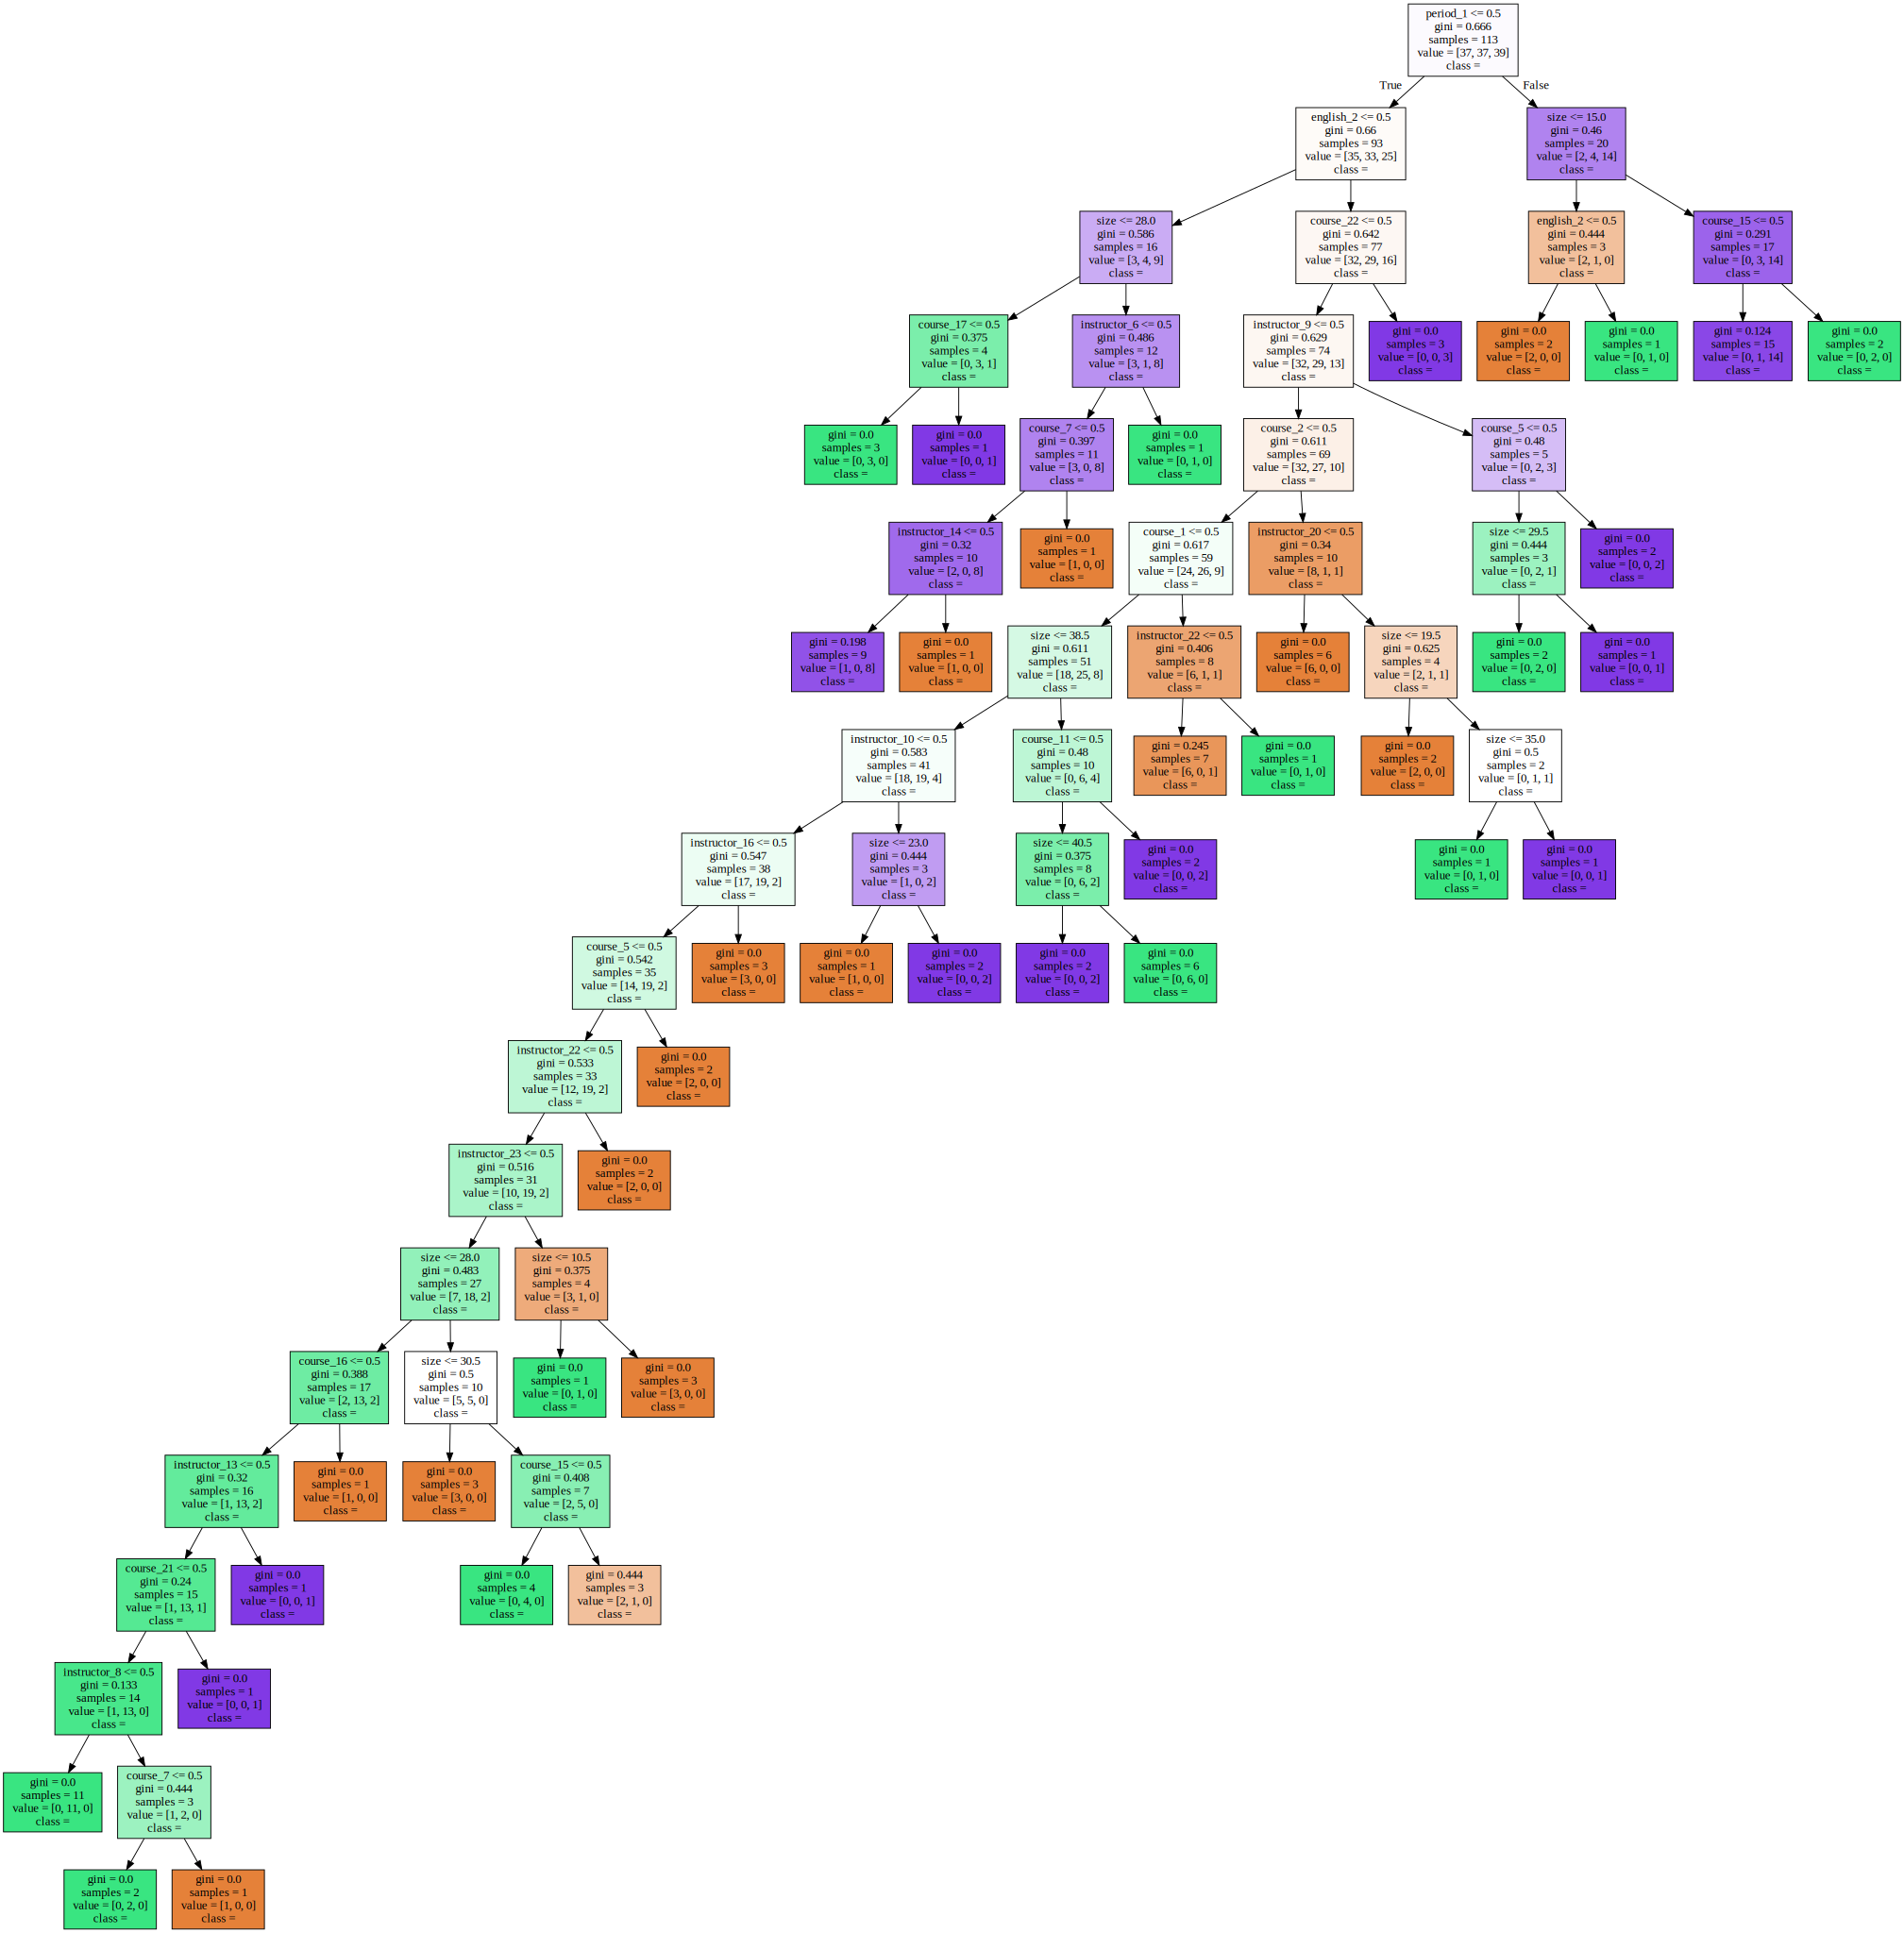

In [38]:
taDot = tree.export_graphviz(taDtOptimal,feature_names=taTrainX.columns,class_names=['差','一般','好'],filled=True)
taAnnOptimal.classes_
taGraphviz = Source(taDot)
taGraphviz

#### 在完整训练集和检验集上检验

In [39]:
print(f'筛选的决策树模型在完整训练集上的准确率是{metrics.accuracy_score(taTrainY,taDtOptimal.predict(taTrainX)):.4f}')

筛选的决策树模型在完整训练集上的准确率是0.9646


In [40]:
print(f'筛选的决策树模型在检验集上的准确率是{metrics.accuracy_score(taTestY,taDtOptimal.predict(taTestX)):.4f}')

筛选的决策树模型在检验集上的准确率是0.5000
